# Importing Libraries and Data

In [1]:
import pandas as pd
import random
import geonamescache
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [2]:
data = pd.read_csv("cleaned_data_only_transactions.csv",parse_dates=['visit_start_time','visit_date'])
data.head()

,visitor_id,visit_number,visit_id,visit_start_time,visit_date,channel_grouping,total_hits,product_name,product_category,product_price,...,region,metro_area,city,hour_of_day,day_of_week,is_mobile,is_desktop,is_tablet,is_new_visitor,is_returning_visitor
0,2385451684587900506,2,1471552163,2016-08-18 20:29:23+00:00,2016-08-18,Organic Search,42,Google Laptop and Cell Phone Stickers,(not set),1990000,...,Washington,Seattle-Tacoma WA,Seattle,20,3,1,0,0,0,1
1,2385451684587900506,2,1471552163,2016-08-18 20:29:23+00:00,2016-08-18,Organic Search,42,Badge Holder,(not set),1990000,...,Washington,Seattle-Tacoma WA,Seattle,20,3,1,0,0,0,1
2,2385451684587900506,2,1471552163,2016-08-18 20:29:23+00:00,2016-08-18,Organic Search,42,Crunch-It Dog Toy,(not set),4990000,...,Washington,Seattle-Tacoma WA,Seattle,20,3,1,0,0,0,1
3,2385451684587900506,2,1471552163,2016-08-18 20:29:23+00:00,2016-08-18,Organic Search,42,Sport Bag,(not set),4990000,...,Washington,Seattle-Tacoma WA,Seattle,20,3,1,0,0,0,1
4,2385451684587900506,2,1471552163,2016-08-18 20:29:23+00:00,2016-08-18,Organic Search,42,Engraved Ceramic Google Mug,(not set),8990000,...,Washington,Seattle-Tacoma WA,Seattle,20,3,1,0,0,0,1


In [3]:
data.shape

(36735, 31)

In [4]:
#Keeping only US_data
data = data[data["country"]=="United States"].reset_index(drop=True).drop(columns=["region","city"])

# Simulating Geographic Data


In [5]:
# Set the random seed for reproducibility
random.seed(42)

# Create a geonamescache instance
gc = geonamescache.GeonamesCache()

# Get the list of US states
us_states = gc.get_us_states()
states_list = list(us_states.keys())

# Get the list of cities
cities = gc.get_cities()

# Create a dictionary to map state codes to their cities
state_to_cities = {}
for city_info in cities.values():
    if city_info['countrycode'] == 'US':  # Ensure the city is in the US
        state_code = city_info['admin1code']
        city_name = city_info['name']
        if state_code in state_to_cities:
            state_to_cities[state_code].append(city_name)
        else:
            state_to_cities[state_code] = [city_name]

# Define weights for states to skew the selection
# # For example, California (CA), Texas (TX), and Florida (FL) are more likely to be chosen
# state_weights = [1 if state not in ['CA', 'TX', 'FL'] else 10 for state in states_list]

# Generate random weights for each state
# state_weights = [random.randint(1, 10) for _ in states_list]
state_weights = [random.randint(1, 50)if state not in ['CA', 'TX', 'FL'] else 50 for state in states_list]

# Get unique visitor_ids
unique_visitors = data['visitor_id'].unique()
# Create a dictionary to store geographic info for each visitor
visitor_geo_info = {}

# Generate random geographic information for each unique visitor
for visitor_id in unique_visitors:
    state_code = random.choices(states_list, weights=state_weights, k=1)[0]
    state_name = us_states[state_code]['name']
    city_name = random.choice(state_to_cities[state_code])
    visitor_geo_info[visitor_id] = {'region': state_name, 'cities': city_name}



# Create a DataFrame from the visitor_geo_info dictionary
visitor_geo_df = pd.DataFrame.from_dict(visitor_geo_info, orient='index').reset_index()
visitor_geo_df.columns = ['visitor_id', 'region', 'cities']

# Merge the geographic information back to the original DataFrame
data = data.merge(visitor_geo_df, on='visitor_id', how='left')

data.head()

,visitor_id,visit_number,visit_id,visit_start_time,visit_date,channel_grouping,total_hits,product_name,product_category,product_price,...,metro_area,hour_of_day,day_of_week,is_mobile,is_desktop,is_tablet,is_new_visitor,is_returning_visitor,region,cities
0,2385451684587900506,2,1471552163,2016-08-18 20:29:23+00:00,2016-08-18,Organic Search,42,Google Laptop and Cell Phone Stickers,(not set),1990000,...,Seattle-Tacoma WA,20,3,1,0,0,0,1,Kentucky,Madisonville
1,2385451684587900506,2,1471552163,2016-08-18 20:29:23+00:00,2016-08-18,Organic Search,42,Badge Holder,(not set),1990000,...,Seattle-Tacoma WA,20,3,1,0,0,0,1,Kentucky,Madisonville
2,2385451684587900506,2,1471552163,2016-08-18 20:29:23+00:00,2016-08-18,Organic Search,42,Crunch-It Dog Toy,(not set),4990000,...,Seattle-Tacoma WA,20,3,1,0,0,0,1,Kentucky,Madisonville
3,2385451684587900506,2,1471552163,2016-08-18 20:29:23+00:00,2016-08-18,Organic Search,42,Sport Bag,(not set),4990000,...,Seattle-Tacoma WA,20,3,1,0,0,0,1,Kentucky,Madisonville
4,2385451684587900506,2,1471552163,2016-08-18 20:29:23+00:00,2016-08-18,Organic Search,42,Engraved Ceramic Google Mug,(not set),8990000,...,Seattle-Tacoma WA,20,3,1,0,0,0,1,Kentucky,Madisonville


# Implementing KMeans Clustering

Optimal number of clusters: 4


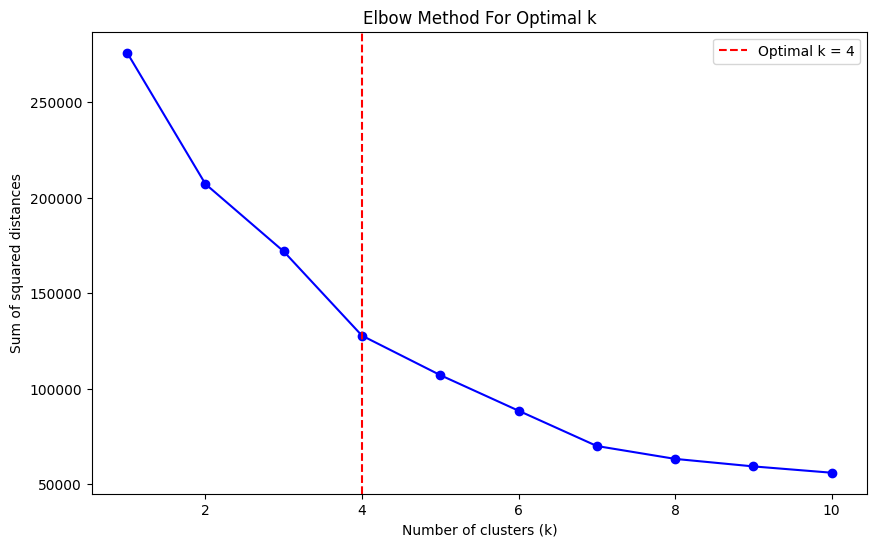

In [6]:
# Select relevant columns for clustering
features_for_clustering = [
    'total_hits', 'total_pageviews', 'total_time_on_site', 
    'hour_of_day', 'day_of_week', 'is_mobile', 'is_desktop', 'is_tablet'
]

# Standardize the data for consistent clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features_for_clustering])

# Use the elbow method to find the optimal number of clusters
# Testing K values from 1 to 10
k_values = range(1, 11)
inertia = []  # Store the inertia (within-cluster sum of squares) for each K value

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Find the elbow point using KneeLocator
K = range(1, 11)  # Test k from 1 to 10
kn = KneeLocator(K, inertia, curve='convex', direction='decreasing')
print('Optimal number of clusters:', kn.knee)

# Plot with the automatically detected elbow point
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=kn.knee, color='red', linestyle='--', label=f'Optimal k = {kn.knee}')
plt.legend()

plt.show()


Note: you may need to restart the kernel to use updated packages.


In [7]:
# Implement K-Means clustering with 5 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)  # Fit and predict cluster labels

# Add the cluster labels to the data
data['cluster'] = cluster_labels

# Analyze the cluster distribution and centroids for insights
cluster_distribution = data['cluster'].value_counts()  # Count of users in each cluster
cluster_centroids = kmeans.cluster_centers_  # Centroids of the clusters

cluster_distribution, cluster_centroids  # Return the distribution and centroids for analysis


(cluster
 0    28542
 1     3651
 3     1901
 2      402
 Name: count, dtype: int64,
 array([[-2.38564824e-01, -2.27868795e-01, -2.42104529e-01,
          2.86576066e-02, -3.08722444e-02, -2.41499127e-01,
          2.67464560e-01, -1.08586053e-01],
        [ 1.97200159e+00,  1.85986699e+00,  1.84811079e+00,
         -7.57196076e-02,  5.82546969e-02, -2.41499127e-01,
          2.67464560e-01, -1.08586053e-01],
        [ 8.50676704e-02,  1.57188249e-01,  3.61539867e-01,
         -4.60525428e-01,  3.66123224e-01, -2.41499127e-01,
         -3.73881310e+00,  9.20928582e+00],
        [-2.23491734e-01, -1.83973124e-01,  9.12991139e-03,
         -1.87460231e-01,  2.74216814e-01,  4.14080171e+00,
         -3.73881310e+00, -1.08586053e-01]]))

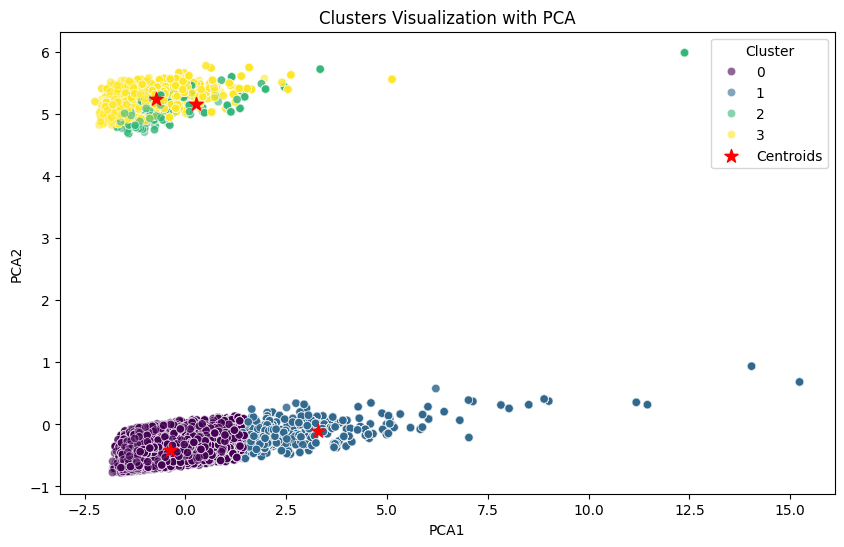

In [8]:
# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

# Add the principal components and cluster labels to the data frame
data['PCA1'] = principal_components[:, 0]
data['PCA2'] = principal_components[:, 1]
data['kmeans_cluster'] = cluster_labels

# Calculate the centroids in the original space and transform them to PCA space
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

# Scatter plot of the PCA results with centroids
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='kmeans_cluster', data=data, palette='viridis', alpha=0.6)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, c='red', label='Centroids', marker='*')
plt.title('Clusters Visualization with PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


C:\Users\Ahmed\AppData\Local\Temp\ipykernel_16900\4206801790.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=data, palette='viridis')


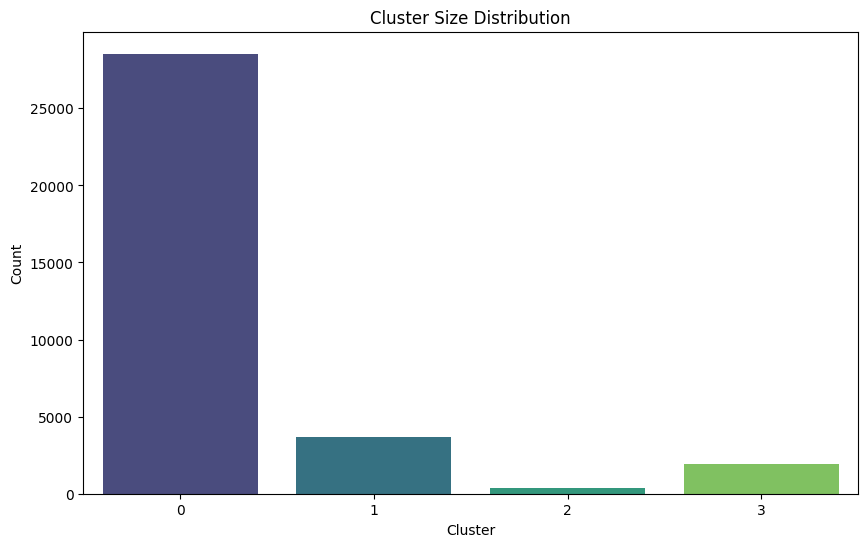

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=data, palette='viridis')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [10]:
kmeans_silhouette = silhouette_score(data_scaled, cluster_labels)
kmeans_davies_bouldin = davies_bouldin_score(data_scaled, cluster_labels)
kmeans_wcss = kmeans.inertia_

In [11]:
# Create DataFrame for KMeans results
kmeans_results = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Within-Cluster Sum of Squares'],
    'Value': [kmeans_silhouette, kmeans_davies_bouldin, kmeans_wcss]
})
kmeans_results

,Metric,Value
0,Silhouette Score,0.479581
1,Davies-Bouldin Index,0.844751
2,Within-Cluster Sum of Squares,127745.680365


## Results Interpretation

**Silhouette Score: 0.479581**

The silhouette score measures how similar an object is to its own cluster compared to other clusters. Values range from -1 to 1, where a higher value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. A score of 0.479581 indicates a reasonable level of cluster cohesion and separation, suggesting that the clusters are fairly well-defined but there might be some overlap.

**Davies-Bouldin Index: 0.844751**

The Davies-Bouldin Index measures the average similarity ratio of each cluster with respect to the other clusters. Lower values indicate better clustering quality. A value of 0.844751 suggests that the clusters are relatively compact and well separated from each other.

**Within-Cluster Sum of Squares (WCSS): 127745.680365**

WCSS measures the total variance within clusters. Lower values indicate that the clusters are more compact. A value of 127745.680365 indicates the sum of squared distances of points within clusters, suggesting a certain level of compactness of the clusters.

# Implementing DBSCAN

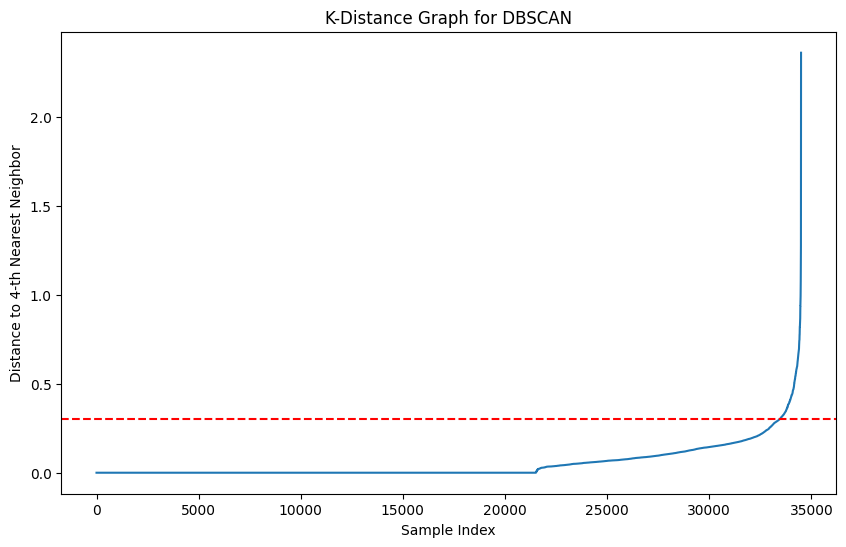

In [12]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(data_scaled)
distances, indices = neighbors_fit.kneighbors(data_scaled)

# Sort the distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=0.3, color='r', linestyle='--')  # Example threshold line, adjust as needed
plt.title('K-Distance Graph for DBSCAN')
plt.xlabel('Sample Index')
plt.ylabel(f'Distance to {k}-th Nearest Neighbor')
plt.show()


In [13]:
# Apply DBSCAN with the chosen eps value
dbscan = DBSCAN(eps=0.3, min_samples=330)
dbscan_labels = dbscan.fit_predict(data_scaled)

# Add DBSCAN labels to the DataFrame
data['dbscan_cluster'] = dbscan_labels

#Visualize DBSCAN Clusters with PCA
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='PCA1', y='PCA2', hue='dbscan_cluster', data=data, palette='viridis', alpha=0.6)
# plt.title('DBSCAN Clusters Visualization with PCA')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
# plt.legend(title='Cluster')
# plt.show()

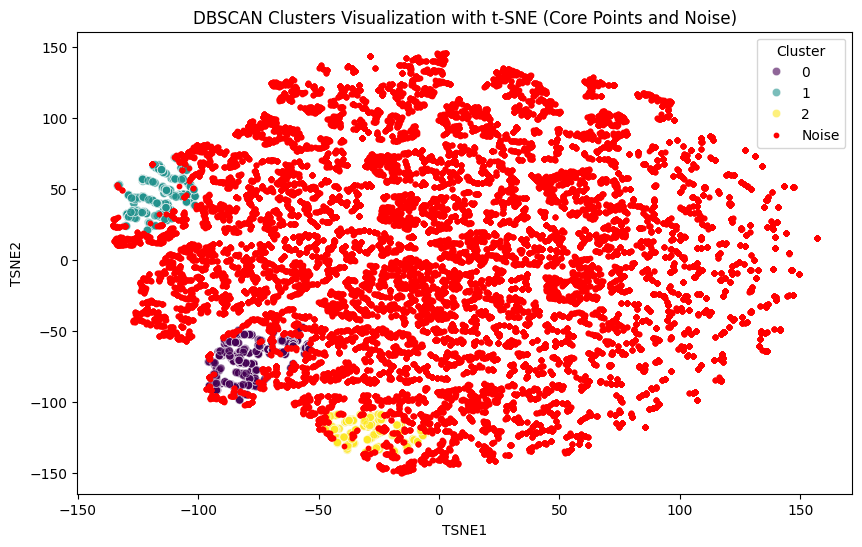

In [14]:
# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(data_scaled)

# Add the t-SNE components to the data frame
data['TSNE1'] = tsne_components[:, 0]
data['TSNE2'] = tsne_components[:, 1]

# Add DBSCAN labels to the DataFrame
data['dbscan_cluster'] = dbscan_labels

# Identify core points and noise points
core_samples_mask = (dbscan_labels != -1)
noise_mask = (dbscan_labels == -1)

# Plot core points and noise points together
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='dbscan_cluster', data=data[core_samples_mask], palette='viridis', alpha=0.6, legend='full')
plt.scatter(data[noise_mask]['TSNE1'], data[noise_mask]['TSNE2'], color='red', label='Noise', s=10)  # Plot noise points in red
plt.title('DBSCAN Clusters Visualization with t-SNE (Core Points and Noise)')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend(title='Cluster', loc='best')
plt.show()


C:\Users\Ahmed\AppData\Local\Temp\ipykernel_16900\118992601.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')


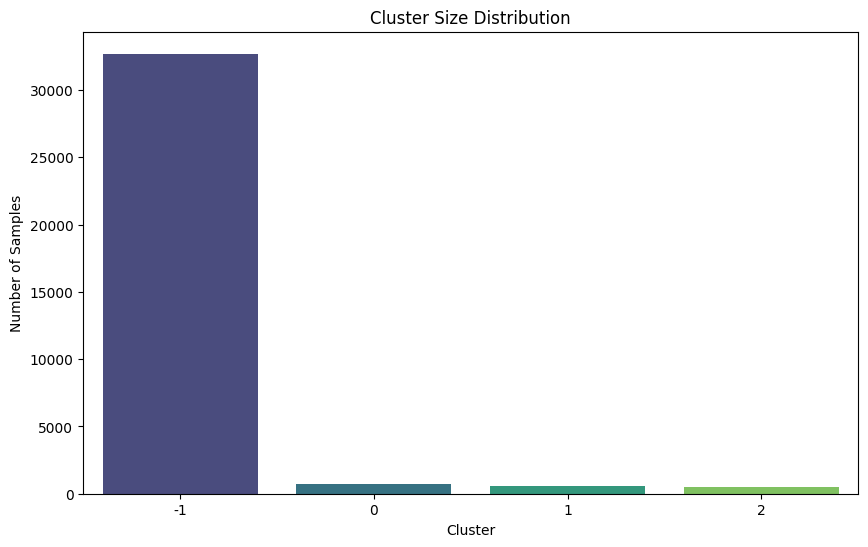

In [15]:
cluster_sizes = pd.Series(dbscan_labels).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Samples')
plt.show()

In [16]:
# Calculate metrics for DBSCAN

# Function to calculate Within-Cluster Sum of Squares
def calculate_wcss(data, labels):
    unique_labels = set(labels)
    wcss = 0
    for label in unique_labels:
        if label != -1:
            cluster_points = data[labels == label]
            centroid = cluster_points.mean(axis=0)
            wcss += ((cluster_points - centroid) ** 2).sum()
    return wcss

dbscan_silhouette = silhouette_score(data_scaled, dbscan_labels)
dbscan_davies_bouldin = davies_bouldin_score(data_scaled, dbscan_labels)
dbscan_wcss = calculate_wcss(data_scaled, dbscan_labels)

In [17]:
# Create DataFrame for DBSCAN results
dbscan_results = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Within-Cluster Sum of Squares'],
    'Value': [dbscan_silhouette, dbscan_davies_bouldin, dbscan_wcss]
})
dbscan_results

,Metric,Value
0,Silhouette Score,-0.314998
1,Davies-Bouldin Index,1.456832
2,Within-Cluster Sum of Squares,153.228166


## Results Interpretation

**Silhouette Score: -0.314998**

A negative silhouette score indicates that many points are assigned to the wrong clusters, as they are closer to points in other clusters than to points in their own cluster. A score of -0.314998 suggests poor clustering quality, with significant overlap and misclassification of points.

**Davies-Bouldin Index: 1.456832**

A higher Davies-Bouldin Index indicates poorer clustering quality. A value of 1.456832 suggests that the clusters are not well separated and are relatively dispersed.

**Within-Cluster Sum of Squares (WCSS): 153.228166**

The WCSS value is much lower compared to KMeans, but this is due to the nature of DBSCAN, which tends to create smaller, denser clusters and treat many points as noise. This WCSS value does not necessarily indicate better or worse clustering without considering the context of how DBSCAN works.

# Implementing Heirachical Clustering

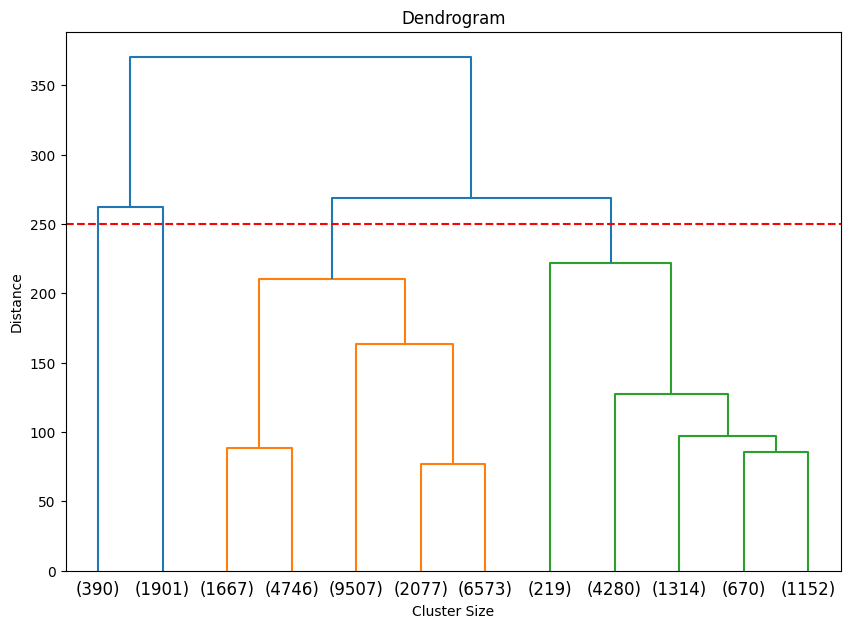

In [18]:
# Perform Hierarchical Clustering
linked = linkage(data_scaled, 'ward')

# Plot the dendrogram with a horizontal line at distance 250
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=12, show_leaf_counts=True)
plt.axhline(y=250, color='r', linestyle='--')
plt.title('Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

In [19]:
# Fit the Agglomerative Clustering model
agg_cluster = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
agg_labels = agg_cluster.fit_predict(data_scaled)



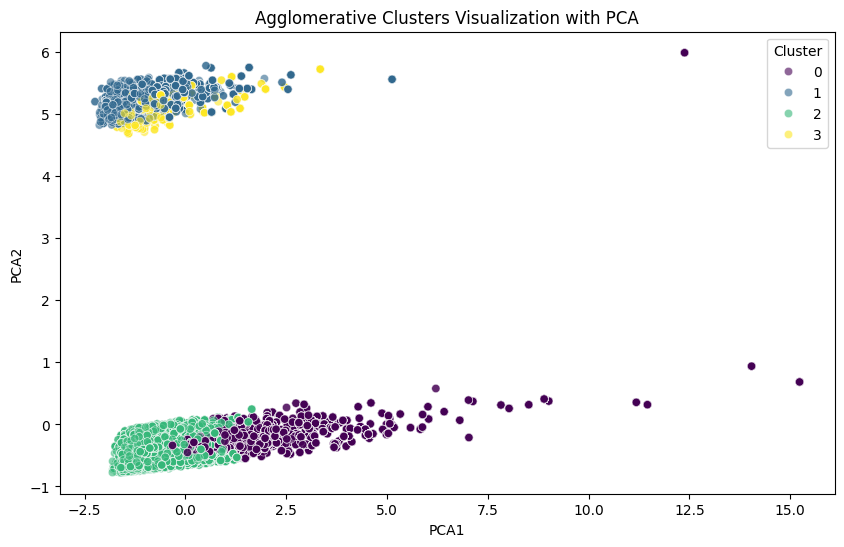

In [20]:
# Visualize Agglomerative Clustering
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)
data['PCA1'] = principal_components[:, 0]
data['PCA2'] = principal_components[:, 1]
data['agg_cluster'] = agg_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='agg_cluster', data=data, palette='viridis', alpha=0.6)
plt.title('Agglomerative Clusters Visualization with PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_16900\1963326465.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')


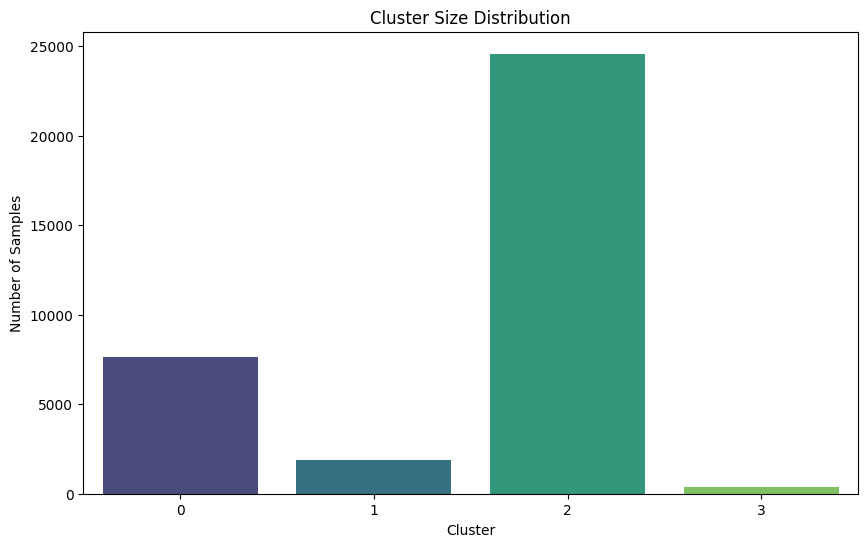

In [21]:
cluster_sizes = pd.Series(agg_labels).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Samples')
plt.show()

In [22]:
# Calculate metrics for Agglomerative Clustering
agg_silhouette = silhouette_score(data_scaled, agg_labels)
agg_davies_bouldin = davies_bouldin_score(data_scaled, agg_labels)
agg_wcss = calculate_wcss(data_scaled, agg_labels)

# Create DataFrame for Agglomerative Clustering results
agg_results = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Within-Cluster Sum of Squares'],
    'Value': [agg_silhouette, agg_davies_bouldin, agg_wcss]
})
agg_results



,Metric,Value
0,Silhouette Score,0.320755
1,Davies-Bouldin Index,1.028105
2,Within-Cluster Sum of Squares,137141.282652


## Results Interpretation

**Silhouette Score: 0.320755**

A silhouette score of 0.320755 indicates that the clusters are reasonably well-defined but not as well separated as those from KMeans. The clusters have moderate cohesion and separation.

**Davies-Bouldin Index: 1.028105**

The Davies-Bouldin Index of 1.028105 indicates that the clusters are less compact and more dispersed compared to KMeans, but better than DBSCAN. The clusters are moderately well separated.

**Within-Cluster Sum of Squares (WCSS): 137141.282652**

The WCSS value for Agglomerative Clustering is slightly higher than that of KMeans, suggesting that the clusters are slightly less compact. This indicates that there is more variability within the clusters.

In [30]:
data[["visit_start_time","visit_date"]] = data[["visit_start_time","visit_date"]].astype(str)

In [31]:
data.to_excel("google_analytics_transactions_data.xlsx",index=False)

In [38]:
transactions = data.groupby(["visitor_id","visit_date","total_transaction_revenue","channel_grouping","browser","traffic_source","country",'cities','region',"total_hits","total_pageviews","total_time_on_site","visit_number","kmeans_cluster","dbscan_cluster","agg_cluster","device_category"]).count()[["product_name"]].rename(columns={"product_name":"products"}).reset_index()
transactions

,visitor_id,visit_date,total_transaction_revenue,channel_grouping,browser,traffic_source,country,cities,region,total_hits,total_pageviews,total_time_on_site,visit_number,kmeans_cluster,dbscan_cluster,agg_cluster,device_category,products
0,213131142648941,2017-04-28,39590000,Direct,Chrome,(direct),United States,Spokane,Washington,14,13,272.00,1,0,-1,2,desktop,1
1,435324061339869,2016-10-21,46790000,Referral,Chrome,(direct),United States,Pooler,Georgia,14,11,627.00,2,0,-1,2,desktop,1
2,562678147042735,2017-04-24,62610000,Referral,Chrome,(direct),United States,Chesterfield,Missouri,18,16,319.00,2,0,-1,2,desktop,1
3,562678147042735,2017-04-24,97700000,Referral,Chrome,(direct),United States,Chesterfield,Missouri,18,16,319.00,2,0,-1,2,desktop,1
4,585708896049892,2016-12-21,45970000,Referral,Chrome,(direct),United States,Murfreesboro,Tennessee,22,20,634.00,1,0,-1,2,desktop,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11281,9991633376050115277,2017-02-18,35590000,Social,Chrome,plus.google.com,United States,Newton,Kansas,17,16,386.00,1,0,-1,2,desktop,1
11282,9994767073213036303,2016-08-09,140320000,Organic Search,Chrome,google,United States,Omaha,Nebraska,42,30,755.00,6,0,-1,2,desktop,6
11283,9997409246962677759,2016-12-09,40360000,Referral,Chrome,(direct),United States,Lafayette,Indiana,86,65,1423.00,2,0,-1,0,desktop,5
11284,9998597322098588317,2016-08-01,102200000,Direct,Chrome,(direct),United States,Newburg,Kentucky,37,33,2041.00,1,0,-1,2,desktop,2


# Cluster Analysis (KMeans)

In [40]:
pd.set_option('display.float_format', '{:.2f}'.format)
# Define a function to get the top N products purchased
def get_top_products(df, n=10):
    return df['products'].value_counts().head(n).index.tolist()

def get_popular_browser(df):
    return df["browser"].value_counts().head(1).index.tolist()

def get_popular_device(df):
    return df["device_category"].value_counts().head(1).index.tolist()

def get_popular_traffic_source(df):
    return df["traffic_source"].value_counts().head(1).index.tolist()

def get_popular_channel_group(df):
    return df["channel_grouping"].value_counts().head(1).index.tolist()

# Group the data by clusters
grouped_data = transactions.groupby('kmeans_cluster')

# Initialize a list to store the results
cluster_metrics = []

# Iterate through each cluster
for cluster, group in grouped_data:
    avg_order_value = group['total_transaction_revenue'].mean()/1000000
    total_page_views = group['total_pageviews'].sum()
    avg_time_on_site = group['total_time_on_site'].mean()
    total_revenue = group['total_transaction_revenue'].sum()/1000000
    browser = get_popular_browser(group)
    device = get_popular_device(group)
    traffic_source = get_popular_traffic_source(group)
    channel_group = get_popular_channel_group(group)
    
    cluster_metrics.append({
        'Cluster': cluster,
        'Average Order Value': avg_order_value,
        'Total Page Views': total_page_views,
        'Average Time on Site': avg_time_on_site,
        'Total Revenue': total_revenue,
        'Browser(preferred)':browser,
        'Device(preferred)': device,
        'Traffic Source(preferred)': traffic_source,
        "Channel Group": channel_group
    })

# Convert the results to a DataFrame
cluster_metrics_df = pd.DataFrame(cluster_metrics)
cluster_metrics_df

,Cluster,Average Order Value,Total Page Views,Average Time on Site,Total Revenue,Browser(preferred),Device(preferred),Traffic Source(preferred),Channel Group
0,0,141.88,253350,940.86,1392998.25,[Chrome],[desktop],[(direct)],[Referral]
1,1,409.61,50481,3634.75,202348.88,[Chrome],[desktop],[(direct)],[Referral]
2,2,58.25,6180,1486.81,9320.37,[Safari],[tablet],[(direct)],[Organic Search]
3,3,66.71,20562,1086.44,54305.71,[Chrome],[mobile],[(direct)],[Organic Search]


# Cluster Analysis(DBSCAN)

In [41]:
# Group the data by DBSCAN clusters
grouped_data = transactions.groupby('dbscan_cluster')

# Initialize a list to store the results
cluster_metrics = []

# Iterate through each cluster
for cluster, group in grouped_data:
    avg_order_value = group['total_transaction_revenue'].mean()/1000000
    total_page_views = group['total_pageviews'].sum()
    avg_time_on_site = group['total_time_on_site'].mean()
    total_revenue = group['total_transaction_revenue'].sum()/1000000
    browser = get_popular_browser(group)
    device = get_popular_device(group)
    traffic_source = get_popular_traffic_source(group)
    channel_group = get_popular_channel_group(group)
    
    cluster_metrics.append({
        'Cluster': cluster,
        'Average Order Value': avg_order_value,
        'Total Page Views': total_page_views,
        'Average Time on Site': avg_time_on_site,
        'Total Revenue': total_revenue,
        'Browser(preferred)':browser,
        'Device(preferred)': device,
        'Traffic Source(preferred)': traffic_source,
        "Channel Group": channel_group
    })

# Convert the results to a DataFrame
cluster_metrics_df = pd.DataFrame(cluster_metrics)
cluster_metrics_df


,Cluster,Average Order Value,Total Page Views,Average Time on Site,Total Revenue,Browser(preferred),Device(preferred),Traffic Source(preferred),Channel Group
0,-1,150.25,315693,1128.40,1567075.23,[Chrome],[desktop],[(direct)],[Referral]
1,0,102.30,6078,462.15,35703.25,[Chrome],[desktop],[(direct)],[Referral]
2,1,116.09,4521,434.33,30879.22,[Chrome],[desktop],[(direct)],[Referral]
3,2,105.04,4281,453.12,25315.51,[Chrome],[desktop],[(direct)],[Referral]


# Cluster Analysis(Agglomerative)

In [26]:
# Group the data by Agglomerative clusters
grouped_data = data.groupby('agg_cluster')

# Initialize a list to store the results
cluster_metrics = []

# Iterate through each cluster
for cluster, group in grouped_data:
    avg_order_value = group['total_transaction_revenue'].mean()/1000000
    total_page_views = group['total_pageviews'].sum()
    avg_time_on_site = group['total_time_on_site'].mean()
    total_revenue = group['total_transaction_revenue'].sum()/1000000
    top_products = get_top_products(group)
    browser = get_popular_browser(group)
    device = get_popular_device(group)
    traffic_source = get_popular_traffic_source(group)
    channel_group = get_popular_channel_group(group)
    
    
    cluster_metrics.append({
        'Cluster': cluster,
        'Average Order Value': avg_order_value,
        'Total Page Views': total_page_views,
        'Average Time on Site': avg_time_on_site,
        'Total Revenue': total_revenue,
        'Top 10 Products Purchased': top_products,
        'Browser(preferred)':browser,
        'Device(preferred)': device,
        'Traffic Source(preferred)': traffic_source,
        "Channel Group": channel_group
    })

# Convert the results to a DataFrame
cluster_metrics_df = pd.DataFrame(cluster_metrics)
cluster_metrics_df


,Cluster,Average Order Value,Total Page Views,Average Time on Site,Total Revenue,Top 10 Products Purchased,Browser(preferred),Device(preferred),Traffic Source(preferred),Channel Group
0,0,526.03,594762,2622.88,4016222.60,"[Google Sunglasses, Google 22 oz Water Bottle,...",[Chrome],[desktop],[(direct)],[Referral]
1,1,151.10,62696,1372.56,287232.58,"[Google Sunglasses, Google Laptop and Cell Pho...",[Chrome],[mobile],[(direct)],[Organic Search]
2,2,229.90,694039,965.75,5648609.71,"[Google Sunglasses, Google Men's 100% Cotton S...",[Chrome],[desktop],[(direct)],[Referral]
3,3,88.99,14091,1572.14,34707.61,"[Google Sunglasses, Google Men's 100% Cotton S...",[Safari],[tablet],[(direct)],[Organic Search]


# Saving Results

In [43]:
transactions.to_excel("transactions.xlsx",index=False)